# NSGA-II baseline on ZDT1 (high dimensionality)

This notebook rebuilds the reference experiment from scratch to evaluate the computational
performance of our NSGA-II implementation across the ZDT problem family. The workflow covers
(1) the table with published results, (2) the full-budget baseline execution, and (3) the
analysis of the generated Pareto front so you can refresh the table with local runs.


## 1. Setup

This cell prepares the common dependencies for the rest of the notebook:
- Locates the VAMOS project root and adds `src/` to `PYTHONPATH` for code reuse.
- Applies Matplotlib/Pandas styles so the published table is easy to inspect.


In [1]:
from __future__ import annotations

import json
import os
import subprocess
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 120)


def resolve_project_root(markers=("pyproject.toml", ".git")):
    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        if any((candidate / marker).exists() for marker in markers):
            return candidate
    raise RuntimeError("Run this notebook inside the VAMOS repository tree.")


PROJECT_ROOT = resolve_project_root()
SRC_DIR = PROJECT_ROOT / "src"
RESULTS_DIR = PROJECT_ROOT / "results" / "ZDT1" / "nsgaii"

if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Project root:", PROJECT_ROOT)
print("Results dir:", RESULTS_DIR)


Project root: C:\Users\nicol\Desktop\VAMOS
Results dir: C:\Users\nicol\Desktop\VAMOS\results\ZDT1\nsgaii


## 2. Published baseline table

The following values come from the published results for both the manual NSGA-II
configuration and AutoNSGA-II at increasing dimensionality. The `NSGA-II-Nico` column is
reserved for logging the best measurement from your local runs.


In [2]:

def _record(problem, variables, time_nsga, time_auto, evals_nsga, evals_auto):

    return {
        "Problem": problem,
        "Variables": variables,
        "Time (h) NSGA-II": time_nsga,
        "Time (h) AutoNSGA-II": time_auto,
        "Evaluations NSGA-II": evals_nsga,
        "Evaluations AutoNSGA-II": evals_auto,
        "NSGA-II-Nico": "-",
        "AutoNSGA-II-Nico": "-",
    }


BASELINE_RECORDS = [
    _record("ZDT1", 2_048, 0.13, 0.02, 1_250_500, 182_356),
    _record("ZDT1", 4_096, 0.51, 0.12, 2_906_100, 484_356),
    _record("ZDT1", 8_192, 2.40, 0.50, 6_622_600, 1_039_156),
    _record("ZDT1", 16_384, 11.19, 2.15, 14_741_200, 2_180_656),
    _record("ZDT1", 32_768, None, 9.04, None, 4_605_556),
    _record("ZDT1", 65_356, None, 31.66, None, 9_494_556),
    _record("ZDT1", 131_072, None, 120.02, None, 19_359_356),
    _record("ZDT2", 2_048, 0.14, 0.02, 1_472_800, 164_756),
    _record("ZDT2", 4_096, 0.62, 0.10, 3_433_100, 429_156),
    _record("ZDT2", 8_192, 2.77, 0.49, 7_676_600, 986_556),
    _record("ZDT2", 16_384, 12.30, 2.28, 17_059_600, 2_358_056),
    _record("ZDT2", 32_768, None, 9.28, None, 4_736_056),
    _record("ZDT2", 65_356, None, 39.19, None, 10_081_856),
    _record("ZDT2", 131_072, None, 138.85, None, 21_703_556),
    _record("ZDT3", 2_048, 0.10, 0.03, 1_089_800, 253_356),
    _record("ZDT3", 4_096, 0.47, 0.16, 2_514_200, 610_956),
    _record("ZDT3", 8_192, 2.08, 0.62, 5_463_000, 1_267_656),
    _record("ZDT3", 16_384, 9.18, 2.68, 11_877_500, 2_820_556),
    _record("ZDT3", 32_768, None, 11.39, None, 6_158_256),
    _record("ZDT3", 65_356, None, 40.69, None, 11_912_856),
    _record("ZDT3", 131_072, None, None, None, None),
    _record("ZDT4*", 2_048, None, 2.62, None, 21_746_882),
    _record("ZDT6", 2_048, 0.45, 0.04, 5_401_100, 291_856),
    _record("ZDT6", 4_096, 1.82, 0.16, 11_482_400, 659_956),
    _record("ZDT6", 8_192, 7.16, 0.66, 24_897_300, 1_374_056),
    _record("ZDT6", 16_384, None, 3.08, None, 3_221_156),
    _record("ZDT6", 32_768, None, 15.51, None, 7_941_156),
    _record("ZDT6", 65_356, None, 63.79, None, 17_685_556),
    _record("ZDT6", 131_072, None, None, None, None),
]
baseline_df = pd.DataFrame(BASELINE_RECORDS)


## 3. Run the baseline (NSGA-II + moocore_v5)

The next cell launches the full-budget NSGA-II baseline. It runs `vamos.main` from the
project root so the artifacts land under `results/ZDT1/nsgaii/`. Adjust the arguments as
needed before uncommenting the function call.


In [ ]:
def run_baseline(engine="moocore", n_var=2_048, max_evaluations=12_500_500, hv_threshold=0.95):
    env = os.environ.copy()
    env.setdefault("PYTHONPATH", str(SRC_DIR))
    cmd = [
        sys.executable,
        "-m",
        "vamos.main",
        "--problem",
        "zdt1",
        "--engine",
        engine,
        "--n-var",
        str(n_var),
        "--max-evaluations",
        str(max_evaluations),
        "--hv-threshold",
        str(hv_threshold),
        "--population-size",
        "100",
        "--offspring-population-size",
        "100",
        "--nsgaii-crossover",
        "sbx",
        "--nsgaii-crossover-prob",
        "0.9",
        "--nsgaii-crossover-eta",
        "20",
        "--nsgaii-mutation",
        "pm",
        "--nsgaii-mutation-prob",
        "1/n",
        "--nsgaii-mutation-eta",
        "20",
        "--nsgaii-repair",
        "random",
        "--selection-pressure",
        "2",
    ]
    print("Running NSGA-II baseline with full evaluation budget...\n")
    print(" ".join(cmd))
    start = time.time()
    subprocess.run(cmd, env=env, cwd=str(PROJECT_ROOT), check=True)
    elapsed = time.time() - start
    hours = elapsed / 3600
    print(f"\nCompleted in {hours:.2f} hours (~{elapsed / 60:.1f} minutes).")
    return hours

# Descomenta la siguiente lÃƒÂ­nea para ejecutar el baseline inmediatamente.
elapsed_hours = run_baseline()


Running NSGA-II baseline with full evaluation budget...

c:\Users\nicol\Desktop\VAMOS\.venv\Scripts\python.exe -m vamos.main --problem zdt1 --engine moocore_v5 --n-var 2048 --max-evaluations 12500500 --hv-threshold 0.95 --population-size 100 --offspring-population-size 100 --nsgaii-crossover sbx --nsgaii-crossover-prob 0.9 --nsgaii-crossover-eta 20 --nsgaii-mutation pm --nsgaii-mutation-prob 1/n --nsgaii-mutation-eta 20 --nsgaii-repair random --selection-pressure 2


CalledProcessError: Command '['c:\\Users\\nicol\\Desktop\\VAMOS\\.venv\\Scripts\\python.exe', '-m', 'vamos.main', '--problem', 'zdt1', '--engine', 'moocore_v5', '--n-var', '2048', '--max-evaluations', '12500500', '--hv-threshold', '0.95', '--population-size', '100', '--offspring-population-size', '100', '--nsgaii-crossover', 'sbx', '--nsgaii-crossover-prob', '0.9', '--nsgaii-crossover-eta', '20', '--nsgaii-mutation', 'pm', '--nsgaii-mutation-prob', '1/n', '--nsgaii-mutation-eta', '20', '--nsgaii-repair', 'random', '--selection-pressure', '2']' returned non-zero exit status 2.

## 3.1 Run AutoNSGA-II (BLX + non-uniform)

This mirrors the baseline cell but applies the AutoNSGA-II configuration: BLX-Î± crossover, non-uniform mutation, tournament size 9, external archive 56, and the 0.95 hypervolume stopping criterion. Results land under `results_autonsga/ZDT1/nsgaii/` so they remain separate from the manual baseline.

In [ ]:
def run_autonsgaii_cli(
    engine="moocore",
    n_var=2_048,
    max_evaluations=200_000,
    hv_threshold=0.95,
    population_size=56,
    offspring_size=14,
    archive_size=56,
    selection_pressure=9,
    crossover_prob=0.88,
    crossover_alpha=0.94,
    mutation_prob="0.45/n",
    mutation_perturbation=0.3,
    repair_strategy="clip",
):
    env = os.environ.copy()
    env.setdefault("PYTHONPATH", str(SRC_DIR))
    env["VAMOS_OUTPUT_ROOT"] = str(PROJECT_ROOT / "results_autonsga")
    cmd = [
        sys.executable,
        "-m",
        "vamos.main",
        "--problem",
        "zdt1",
        "--engine",
        engine,
        "--n-var",
        str(n_var),
        "--max-evaluations",
        str(max_evaluations),
        "--hv-threshold",
        str(hv_threshold),
        "--population-size",
        str(population_size),
        "--offspring-population-size",
        str(offspring_size),
        "--external-archive-size",
        str(archive_size),
        "--selection-pressure",
        str(selection_pressure),
        "--nsgaii-crossover",
        "blx_alpha",
        "--nsgaii-crossover-prob",
        str(crossover_prob),
        "--nsgaii-crossover-alpha",
        str(crossover_alpha),
        "--nsgaii-mutation",
        "non_uniform",
        "--nsgaii-mutation-prob",
        str(mutation_prob),
        "--nsgaii-mutation-perturbation",
        str(mutation_perturbation),
        "--nsgaii-repair",
        repair_strategy,
    ]
    print("Running AutoNSGA-II configuration with BLX + non-uniform...\n")
    print(" ".join(cmd))
    start = time.time()
    subprocess.run(cmd, env=env, cwd=str(PROJECT_ROOT), check=True)
    elapsed = time.time() - start
    hours = elapsed / 3600
    print(f"\nCompleted in {hours:.2f} hours (~{elapsed / 60:.1f} minutes).")
    return hours


# Uncomment the line below to launch AutoNSGA-II immediately.
auto_elapsed_hours = run_autonsgaii_cli()

Running AutoNSGA-II configuration with BLX + non-uniform...

c:\Users\nicol\Desktop\VAMOS\.venv\Scripts\python.exe -m vamos.main --problem zdt1 --engine moocore_v5 --n-var 2048 --max-evaluations 200000 --hv-threshold 0.95 --population-size 56 --offspring-population-size 14 --external-archive-size 56 --selection-pressure 9 --nsgaii-crossover blx_alpha --nsgaii-crossover-prob 0.88 --nsgaii-crossover-alpha 0.94 --nsgaii-mutation non_uniform --nsgaii-mutation-prob 0.45/n --nsgaii-mutation-perturbation 0.3 --nsgaii-repair clip

Completed in 0.01 hours (~0.5 minutes).


## 4. Load the latest run and update the table

The `find_latest_run` helper scans `results/ZDT1/nsgaii/**/seed_*/metadata.json`, picks the
execution that matches `(problem = zdt1, n_var = 2048, max evaluations = 12,500,500)` and
updates `NSGA-II-Nico` with the measured wall-clock time.


In [ ]:
if 'resolve_project_root' not in globals():
    raise RuntimeError('Run the setup cell first.')

if 'PROJECT_ROOT' not in globals():
    PROJECT_ROOT = resolve_project_root()
if 'SRC_DIR' not in globals():
    SRC_DIR = PROJECT_ROOT / 'src'
if 'RESULTS_DIR' not in globals():
    RESULTS_DIR = PROJECT_ROOT / 'results' / 'ZDT1' / 'nsgaii'
if 'AUTO_RESULTS_DIR' not in globals():
    AUTO_RESULTS_DIR = PROJECT_ROOT / 'results_autonsga' / 'ZDT1' / 'nsgaii'
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))


def find_latest_run(results_dir, problem='zdt1', n_var=2_048, max_evaluations=12_500_500):
    if not results_dir.exists():
        return None
    candidates = []
    for backend_dir in results_dir.iterdir():
        if not backend_dir.is_dir():
            continue
        for meta_path in backend_dir.glob('seed_*/metadata.json'):
            with meta_path.open('r', encoding='utf-8') as fh:
                meta = json.load(fh)
            prob = meta.get('problem', {})
            if prob.get('key') != problem:
                continue
            if prob.get('n_var') != n_var:
                continue
            if meta.get('max_evaluations') != max_evaluations:
                continue
            candidates.append((meta_path.stat().st_mtime, meta_path, meta))
    if not candidates:
        return None
    return max(candidates, key=lambda item: item[0])


def _format_metrics(meta):
    hours = meta['metrics']['time_ms'] / 1000 / 3600
    evals = meta['metrics']['evaluations']
    return f"{hours:.2f} h / {evals:,}"


AUTO_MAX_EVAL = 200_000
latest = find_latest_run(RESULTS_DIR)
latest_auto = find_latest_run(AUTO_RESULTS_DIR, max_evaluations=AUTO_MAX_EVAL)

updated_df = baseline_df.copy()
LATEST_RUN_PATH = None
LATEST_FUN_PATH = None
AUTO_LATEST_RUN_PATH = None
AUTO_LATEST_FUN_PATH = None

if latest is None:
    print('No matching NSGA-II baseline metadata found; run the baseline experiment first.')
else:
    _, meta_path, meta = latest
    mask = (updated_df['Problem'] == 'ZDT1') & (updated_df['Variables'] == 2_048)
    updated_df.loc[mask, 'NSGA-II-Nico'] = _format_metrics(meta)
    LATEST_RUN_PATH = meta_path
    artifacts = meta.get('artifacts', {})
    fun_name = artifacts.get('fun', 'FUN.csv')
    LATEST_FUN_PATH = meta_path.parent / fun_name
    print(f'Latest NSGA-II metadata: {meta_path}')
    print(f'Pareto front (FUN): {LATEST_FUN_PATH}')

if latest_auto is None:
    print('No matching AutoNSGA-II metadata found; run the AutoNSGA-II cell first.')
else:
    _, auto_meta_path, auto_meta = latest_auto
    mask = (updated_df['Problem'] == 'ZDT1') & (updated_df['Variables'] == 2_048)
    updated_df.loc[mask, 'AutoNSGA-II-Nico'] = _format_metrics(auto_meta)
    AUTO_LATEST_RUN_PATH = auto_meta_path
    artifacts = auto_meta.get('artifacts', {})
    auto_fun_name = artifacts.get('fun', 'FUN.csv')
    AUTO_LATEST_FUN_PATH = auto_meta_path.parent / auto_fun_name
    print(f'AutoNSGA-II metadata: {auto_meta_path}')
    print(f'AutoNSGA-II Pareto front (FUN): {AUTO_LATEST_FUN_PATH}')

display(updated_df)

Latest NSGA-II metadata: C:\Users\nicol\Desktop\VAMOS\results\ZDT1\nsgaii\moocore_v5\seed_42\metadata.json
Pareto front (FUN): C:\Users\nicol\Desktop\VAMOS\results\ZDT1\nsgaii\moocore_v5\seed_42\FUN.csv
AutoNSGA-II metadata: C:\Users\nicol\Desktop\VAMOS\results_autonsga\ZDT1\nsgaii\moocore_v5\seed_42\metadata.json
AutoNSGA-II Pareto front (FUN): C:\Users\nicol\Desktop\VAMOS\results_autonsga\ZDT1\nsgaii\moocore_v5\seed_42\FUN.csv


,Problem,Variables,Time (h) NSGA-II,Time (h) AutoNSGA-II,Evaluations NSGA-II,Evaluations AutoNSGA-II,NSGA-II-Nico,AutoNSGA-II-Nico
0,ZDT1,2048,0.1300,0.0200,1250500.0,182356.0,"0.03 h / 700,800","0.01 h / 173,656"
1,ZDT1,4096,0.5100,0.1200,2906100.0,484356.0,-,-
2,ZDT1,8192,2.4000,0.5000,6622600.0,1039156.0,-,-
3,ZDT1,16384,11.1900,2.1500,14741200.0,2180656.0,-,-
4,ZDT1,32768,NaN,9.0400,NaN,4605556.0,-,-
5,ZDT1,65356,NaN,31.6600,NaN,9494556.0,-,-
6,ZDT1,131072,NaN,120.0200,NaN,19359356.0,-,-
7,ZDT2,2048,0.0414,0.0055,678000.0,158200.0,"0.04 h / 678,000","0.01 h / 158,200"
8,ZDT2,4096,0.6200,0.1000,3433100.0,429156.0,-,-
9,ZDT2,8192,2.7700,0.4900,7676600.0,986556.0,-,-


## 5. Plot the most recent Pareto front

Once a matching `FUN.csv` exists for the run above, this cell loads the `(f1, f2)` pairs and
plots the approximate front.


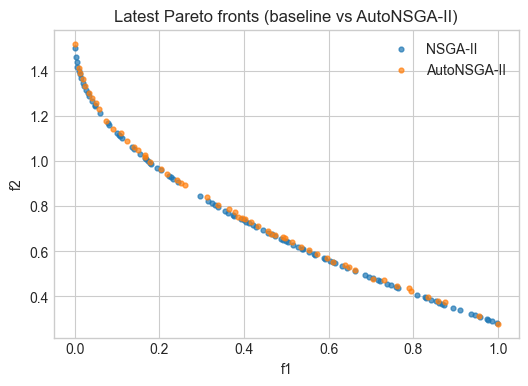

In [ ]:
baseline_fun_path = Path(globals().get('LATEST_FUN_PATH')) if globals().get('LATEST_FUN_PATH') else None
auto_fun_path = Path(globals().get('AUTO_LATEST_FUN_PATH')) if globals().get('AUTO_LATEST_FUN_PATH') else None

if (baseline_fun_path is None or not baseline_fun_path.exists()) and (auto_fun_path is None or not auto_fun_path.exists()):
    print("No Pareto front available. Run the ingestion cell first to capture baseline and/or AutoNSGA-II artifacts.")
else:
    fig, ax = plt.subplots(figsize=(6, 4))
    summaries = []

    def _plot_front(csv_path, label, color):
        front_df = pd.read_csv(csv_path, header=None, names=["f1", "f2"])
        ax.scatter(front_df["f1"], front_df["f2"], s=12, alpha=0.7, label=label, color=color)
        summary = front_df.describe().transpose()
        summary['label'] = label
        summaries.append(summary)

    if baseline_fun_path and baseline_fun_path.exists():
        _plot_front(baseline_fun_path, "NSGA-II", "#1f77b4")
    if auto_fun_path and auto_fun_path.exists():
        _plot_front(auto_fun_path, "AutoNSGA-II", "#ff7f0e")

    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_title("Latest Pareto fronts (baseline vs AutoNSGA-II)")
    if summaries and len(summaries) > 1:
        ax.legend()
    plt.show()

    if summaries:
        combined = pd.concat(summaries).set_index('label', append=True).swaplevel(0, 1)
        display(combined.style.format(precision=4))